##<b>VUE-net:</b> Semantic Segmentation of Urban Environment

**Authors:**

*   Artico Giovanni
*   Giacomin Marco
*   Toffolon Mattia

*Deep Learning Project (Università degli Studi di Padova, A.A. 2023/2024)*

---


**DATASETS LOADING INSTRUCTIONS:**

PointNet dataset (used to generate the training dataset and to test the model) \
link: https://drive.google.com/drive/folders/1_xPLa_rMIT3ggSSnp1W5mB74mojlWqvH?usp=sharing

VUE-net dataset (generated dataset used for training and validation) \
link: https://drive.google.com/drive/folders/1fzBK6_Ohv4WqCjSsOSDwALzuF-UZo7Tq?usp=drive_link

To add a link to the dataset in your Google Drive main folder, you need to:


1.   Click on the link
2.   Right click on "dataset"
3.   Click Add shortcut to Drive

When you will mount your drive folder in Colab you will find this folder without the need of re-uploading it.

# Install/import required packages

In [ ]:
!pip install open3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.7 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
import numpy as np
import random
import math
import time
import struct
import os

# pyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# visualization and voxelling operations
import open3d as o3d
import plotly.graph_objects as go
from matplotlib import pyplot as plt

from mpl_toolkits import mplot3d
from functools import reduce

import time
import random

# Connect and mount your Google Drive

For simplicity we assume the folders were mounted under the root of the google drive

In [ ]:
from google.colab import drive
drive_path = '/content/drive'
drive.mount(drive_path)

Mounted at /content/drive


# Select the first GPU (if available)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# General Parameters

In [ ]:
numpoints = 20000 # [number of points]
max_dist = 15     # [meters]
min_dist = 4      # [meters]

# transform distances to squares (code optimization)
max_dist *= max_dist
min_dist *= min_dist

size_float = 4
size_small_int = 2

dataset_path = os.path.join(drive_path, "MyDrive", "dataset")
#change the following line with an existing folder in your drive root if you want to generate your own dataset
new_dataset_path = os.path.join(drive_path, "MyDrive", "dataset_vox")

side_voxel_grid = 32 #number of voxels per dimension
num_classes = 25
new_num_classes = num_classes + 1

# Read/Modify Data utilities

The following utilities are taken from the Pointnet notebook to open, read and sample the Semantic Kitti dataset

In [ ]:
def sample(pointcloud, labels, numpoints_to_sample):
  """
    INPUT
        pointcloud          : list of 3D points
        labels              : list of integer labels
        numpoints_to_sample : number of points to sample
  """
  tensor = np.concatenate((pointcloud, np.reshape(labels, (labels.shape[0], 1))), axis= 1)
  tensor = np.asarray(random.choices(tensor, weights=None, cum_weights=None, k=numpoints_to_sample))
  pointcloud_ = tensor[:, 0:3]
  labels_ = tensor[:, 3]
  labels_ = np.array(labels_, dtype=np.int_)
  return pointcloud_, labels_

In [ ]:
def readpc(pcpath, labelpath, reduced_labels=True):
  """
    INPUT
        pcpath         : path to the point cloud ".bin" file
        labelpath      : path to the labels ".label" file
        reduced_labels : flag to select which label encoding to return
                        [True]  -> values in range [0, 1, 2]   -- default
                        [False] -> all Semantic-Kitti dataset original labels
  """

  pointcloud, labels = [], []

  with open(pcpath, "rb") as pc_file, open(labelpath, "rb") as label_file:
    byte = pc_file.read(size_float*4)
    label_byte = label_file.read(size_small_int)
    _ = label_file.read(size_small_int)

    while byte:
      x,y,z, _ = struct.unpack("ffff", byte)      # unpack 4 float values
      label = struct.unpack("H", label_byte)[0]   # unpach 1 Unsigned Short value

      d = x*x + y*y + z*z       # Euclidean norm

      if min_dist<d<max_dist:
          pointcloud.append([x, y, z])
          if reduced_labels:            # for reduced labels range
            labels.append(label_remap[label])
          else:                         # for full labels range
            labels.append(label)

      byte = pc_file.read(size_float*4)
      label_byte = label_file.read(size_small_int)
      _ = label_file.read(size_small_int)


  pointcloud  = np.array(pointcloud)
  labels      = np.array(labels)

  # return fixed_sized lists of points/labels (fixed size: numpoints)
  return sample(pointcloud, labels, numpoints)


In [ ]:
label_remap = {
  0 :  0, # "unlabeled"
  1 :  0, # "outlier"
  10:  1, # "car"
  11:  2, # "bicycle"
  13:  3, # "bus"
  15:  4, # "motorcycle"
  16:  5, # "on-rails"
  18:  6, # "truck"
  20:  7, # "other-vehicle"
  30:  8, # "person"
  31:  9, # "bicyclist"
  32:  10, # "motorcyclist"
  40:  11, # "road"
  44:  12, # "parking"
  48:  13, # "sidewalk"
  49:  14, # "other-ground"
  50:  15, # "building"
  51:  16, # "fence"
  52:  17, # "other-structure"
  60:  18, # "lane-marking"
  70:  19, # "vegetation"
  71:  20, # "trunk"
  72:  21, # "terrain"
  80:  22, # "pole"
  81:  23, # "traffic-sign"
  99:  24, # "other-object"
  252: 1, # "moving-car"
  253: 9, # "moving-bicyclist"
  254: 8, # "moving-person"
  255: 10, # "moving-motorcyclist"
  256: 5, # "moving-on-rails"
  257: 3, # "moving-bus"
  258: 6, # "moving-truck"
  259: 7, # "moving-other-vehicle"
}

In [ ]:
remap_color_scheme = [
  [0, 0, 0],        # "unlabeled", "outlier"
  [245, 150, 100],  # "car"
  [245, 230, 100],  # "bicycle"
  [250, 80, 100],   # "bus"
  [150, 60, 30],    # "motorcycle"
  [255, 0, 0],      # "on-rails"
  [180, 30, 80],    # "truck"
  [255, 0, 0],      # "other-vehicle"
  [30, 30, 255],    # "person"
  [200, 40, 255],   # "bicyclist"
  [90, 30, 150],    # "motorcyclist"
  [255, 0, 255],    # "road"
  [255, 150, 255],  # "parking"
  [75, 0, 75],      # "sidewalk"
  [75, 0, 175],     # "other-ground"
  [0, 200, 255],    # "building"
  [50, 120, 255],   # "fence"
  [0, 150, 255],    # "other-structure"
  [170, 255, 150],  # "lane-marking"
  [0, 175, 0],      # "vegetation"
  [0, 60, 135],     # "trunk"
  [80, 240, 150],   # "terrain"
  [150, 240, 255],  # "pole"
  [0, 0, 255],      # "traffic-sign"
  [255, 255, 50],   # "other-object"
  [0, 0, 0],        # "empty"
]

In [ ]:
label_name_map = {
    0: "unlabeled",
    1: "car",
    2: "bicycle",
    3: "bus",
    4: "motorcycle",
    5: "on-rails",
    6: "truck",
    7: "other-vehicle",
    8: "person",
    9: "bicyclist",
    10: "motorcyclist",
    11: "road",
    12: "parking",
    13: "sidewalk",
    14: "other-ground",
    15: "building",
    16: "fence",
    17: "other-structure",
    18: "lane-marking",
    19: "vegetation",
    20: "trunk",
    21: "terrain",
    22: "pole",
    23: "traffic-sign",
    24: "other-object",
    25: "empty-voxel"
}

In [ ]:
def remap_to_bgr(integer_labels, color_scheme):
  bgr_labels = []
  for n in integer_labels:
    bgr_labels.append(color_scheme[int(n)][::-1])
  np_bgr_labels = np.array(bgr_labels)
  return np_bgr_labels

# PointCloud voxelization

**Each pointcloud in the original dataset needs to be converted into a grid of voxels with the corresponding labels. \\
The following functions allow to perform this operation on batches of samples.**

The function voxel_grid_from_pointcloud() transforms the given pointcloud into a voxel grid of given dimensions. \\
The grid is create via a open3d function and later converted into a pytorch tensor. If any point lies into a voxel, then that voxel is set as occupied (value=1) otherwise stays empty (value=0). \\

For the voxel labels we want to have a probability distribution over the classes.
Thefore, each empty voxel is set to have probability 1 of belonging to class 26 (empty voxel). The remaining voxels instead, have for each class a counter of how many points of that class in the cloud correspond to that voxel. These counters will be normalized later.

In [ ]:
def voxel_grid_from_pointcloud(pointcloud_vec, label_vec, voxel_size, grid_dimensions, label_dimensions):
    # Voxelization
    start = time.time()
    pointcloud = o3d.geometry.PointCloud()
    pointcloud.points = o3d.utility.Vector3dVector(pointcloud_vec)
    voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pointcloud, voxel_size=voxel_size)

    # Get voxel grid as numpy array
    voxel_array = voxel_grid.get_voxels()

    # Convert voxel array to torch tensor
    tensor = torch.zeros(grid_dimensions, dtype=torch.float32)
    labels_ret = torch.zeros(label_dimensions, dtype=torch.float32)
    for voxel in voxel_array:
        x, y, z = voxel.grid_index
        tensor[0, x, y, z] = 1  # Set voxel as occupied

    # Transform labels
    point_label = zip(pointcloud_vec, label_vec)
    for p, l in point_label:
      coord = voxel_grid.get_voxel(p)
      labels_ret[l, coord[0], coord[1], coord[2]] += 1

    # All empty voxels are labeled as empty (class 26)
    start = time.time()
    for x in range(grid_dimensions[1]):
      for y in range(grid_dimensions[2]):
          for z in range(grid_dimensions[3]):
            if tensor[0, x, y, z] != 1:
              labels_ret[num_classes, x, y, z] = 1

    return tensor, labels_ret, voxel_grid

transform_pointcloud() defines the dimensions of the voxel grid and transforms the given pointcloud and labels thorugh voxel_grid_from_pointcloud(). \\
It must be noted that an additional class with respect to the original labels (class 26) is needed in order to allow the model to classify a voxel as empty.
Therefore, new_num_classes is used instead of num_classes. \\
**WARNING**: Do **NOT** use this function by itself if you care about the resulting classes, as it doesn't normalize the labels

In [ ]:
def transform_pointcloud(pointcloud, labels, side=32):
  lenx = torch.max(pointcloud[:,0])-torch.min(pointcloud[:,0])
  leny = torch.max(pointcloud[:,1])-torch.min(pointcloud[:,1])
  lenz = torch.max(pointcloud[:,2])-torch.min(pointcloud[:,2])
  voxel_size = max((lenx, leny, lenz))/(side-1)
  grid_dimensions = (1, side, side, side)                 # Voxel grid dimensions (width, height, depth)
  label_dimensions = (new_num_classes, side, side, side)  # Labels tensor dimensions (new_num_classes, width, height, depth)

  # Transform point cloud into voxel grid
  return voxel_grid_from_pointcloud(pointcloud, labels, voxel_size, grid_dimensions, label_dimensions)

batch_voxelize() transforms a given batch of pointclouds into the corresponding batch a voxelgrids through the previous functions. \\
Also, here we normalize the labels before returning them.

In [ ]:
def batch_voxelize(batch_pc, batch_labels, side=32):
  assert batch_pc.shape[0]==batch_labels.shape[0]
  acc_vox = []
  acc_lab = []
  grids = []
  for i in range(batch_pc.shape[0]):
    vox, lab, voxel_grid = transform_pointcloud(batch_pc[i], batch_labels[i], side)
    acc_vox.append(vox)
    acc_lab.append(lab)
    grids.append(voxel_grid)
  # We normalize the labels in order to have probability distributions over the classes as true labels
  return torch.stack(acc_vox), torch.nn.functional.normalize(torch.stack(acc_lab), p=1, dim=1), grids

In [ ]:
# This version of the function simply doesn't return the grid objects which aren't needed to create the new dataset

def batch_voxelize_for_dataset_creation(batch_pc, batch_labels, side=32):
  assert batch_pc.shape[0]==batch_labels.shape[0]
  acc_vox = []
  acc_lab = []
  for i in range(batch_pc.shape[0]):
    vox, lab, _ = transform_pointcloud(batch_pc[i], batch_labels[i], side)
    acc_vox.append(vox)
    acc_lab.append(lab)
  return torch.stack(acc_vox), torch.nn.functional.normalize(torch.stack(acc_lab), p=1, dim=1)

## Data Transformation

In [ ]:
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0)
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

In [ ]:
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

In [ ]:
def default_transforms():
    return transforms.Compose([
                                Normalize(),
                                ToTensor()
                              ])

# Dataset classes definition

PointData class allows the creation of subsets of the original dataset of pointclouds and the extraction of its samples with the corresponding labels. The code for this is taken from the PointNet notebook

In [ ]:
class PointData(Dataset):
    def __init__(self, dataset_path, transform=default_transforms(), start=0, end=1000):
        """
          INPUT
              dataset_path: path to the dataset folder
              transform   : transform function to apply to point cloud
              start       : index of the first file that belongs to dataset
              end         : index of the first file that do not belong to dataset
        """
        self.dataset_path = dataset_path
        self.transforms = transform

        self.pc_path = os.path.join(self.dataset_path, "sequences", "00", "velodyne")
        self.lb_path = os.path.join(self.dataset_path, "sequences", "00", "labels")

        self.pc_paths = os.listdir(self.pc_path)
        self.lb_paths = os.listdir(self.lb_path)
        assert(len(self.pc_paths) == len(self.lb_paths))

        self.start = start
        self.end   = end

        # clip paths according to the start and end ranges provided in input
        self.pc_paths = self.pc_paths[start: end]
        self.lb_paths = self.lb_paths[start: end]

    def __len__(self):
        return len(self.pc_paths)

    def __getitem__(self, idx):
      item_name = str(idx + self.start).zfill(6)
      pcpath = os.path.join(self.pc_path, item_name + ".bin")
      lbpath = os.path.join(self.lb_path, item_name + ".label")

      # load points and labels
      pointcloud, labels = readpc(pcpath, lbpath)

      # transform
      torch_pointcloud  = torch.from_numpy(pointcloud)
      torch_labels      = torch.from_numpy(labels)

      return torch_pointcloud, torch_labels

VoxelData class allows the creation of subsets of the new dataset made of the voxelized pointclouds and the extraction of its samples with the corresponding labels.

In [ ]:
class VoxelData(Dataset):
    def __init__(self, dataset_path, start=0, end=1000):
      self.dataset_path = dataset_path
      self.vg_path      = os.path.join(self.dataset_path, "voxelgrids")
      self.lb_path      = os.path.join(self.dataset_path, "labels")

      self.vg_paths = os.listdir(self.vg_path)
      self.lb_paths = os.listdir(self.lb_path)
      assert(len(self.vg_paths) == len(self.lb_paths))

      self.start = start
      self.end   = end

      self.vg_paths = self.vg_paths[start: end]
      self.lb_paths = self.lb_paths[start: end]

    def __len__(self):
      return len(self.vg_paths)

    def __getitem__(self, idx):
      item_name = str(idx + self.start).zfill(6)
      vgpath = os.path.join(self.vg_path, item_name + ".pt")
      lbpath = os.path.join(self.lb_path, item_name + ".pt")

      voxelgrid = torch.load(vgpath)
      labels    = torch.load(lbpath)

      # The old tensor batch dimension isn't useful and therofore it's removed
      return voxelgrid.squeeze(0), labels.squeeze(0)

# Voxelized pointclouds dataset generation

The following function creates and saves the new dataset made of voxel grid and label tensors of the original dataset samples (pointclouds). \\
The choice of creating a new dataset was taken to not have an overhead in training time due to the samples format conversion.\
We assume the folder specified is already present with subfolders "voxel_grids" and "labels"

In [ ]:
def generate_data(ds_loader):
  for i, data in enumerate(ds_loader, 0):
        inputs, labels = data
        vox, lab = batch_voxelize_for_dataset_creation(inputs, labels)
        if i % 10 == 9:
          print("Cloud", i+1, "voxelized")
        torch.save(vox, new_dataset_path + "/test_v/" + str(i).rjust(6, '0') + ".pt")
        torch.save(lab, new_dataset_path + "/test_l/" + str(i).rjust(6, '0') + ".pt")
# uncomment the following lines to generate dataset
# ds = PointData(dataset_path, start=0, end=1000)
# ds_loader = DataLoader( dataset=ds, batch_size=1, shuffle=False )
# generate_data(ds_loader)

Training, Validation and Test sets are created and loaded. Note that training and validation are performed on the voxelized samples and test on the original pointclouds. Also, samples in the training set are shuffled.

In [ ]:
train_ds  = VoxelData(new_dataset_path, start=0,   end=750)
val_ds    = VoxelData(new_dataset_path, start=750, end=900)
test_ds   = PointData(dataset_path,     start=900, end=1000)

In [ ]:
train_loader  = DataLoader( dataset=train_ds,  batch_size=10, shuffle=True  )
val_loader    = DataLoader( dataset=val_ds,    batch_size=10, shuffle=False )
test_loader   = DataLoader( dataset=test_ds,   batch_size=5,  shuffle=False )

# Network Definition


In this section our Deep Neural Network is defined. The following image illustrates our model. \\

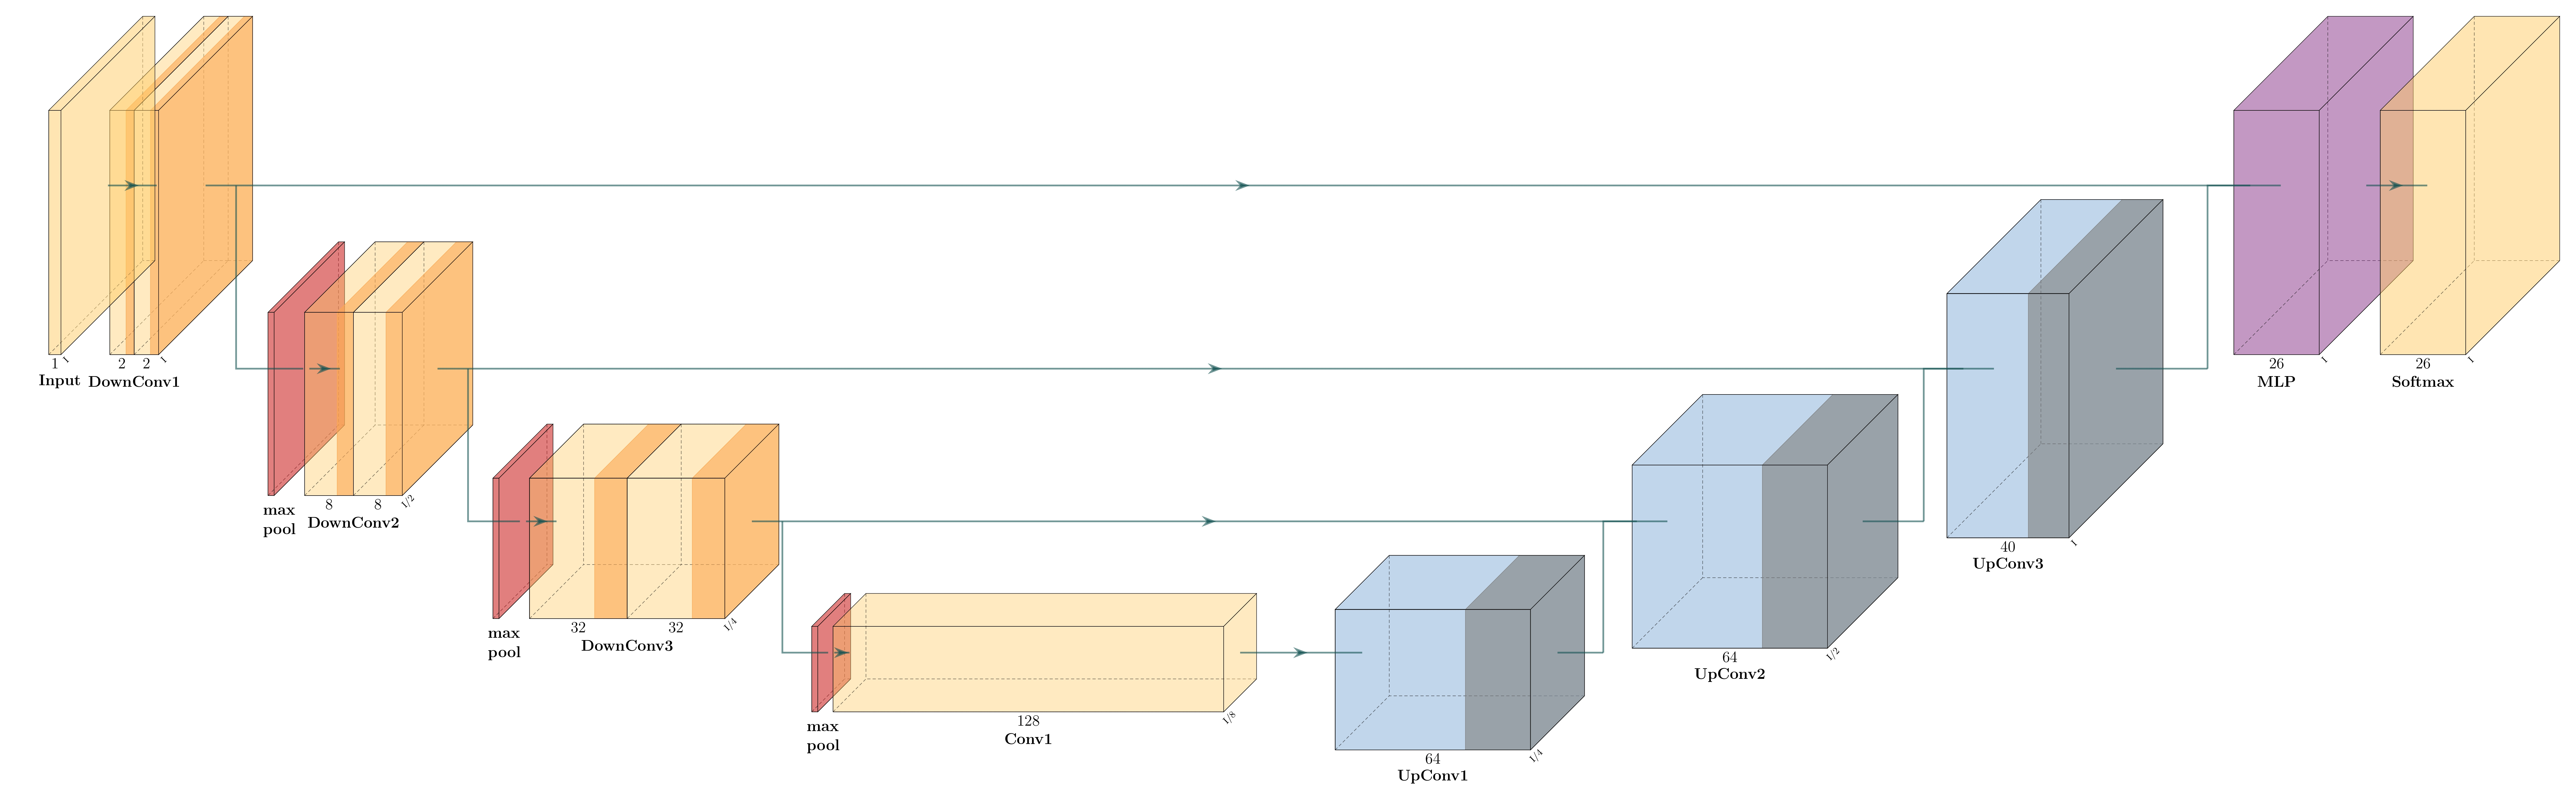

As it can be seen, our model is highly inspired by U-net. This architecture was choosen since, through to upsampling, it is able to solve the sparsity problem that affects our starting voxel grids which is caused by the random sampling of the pointclouds used in the generation of the new samples.

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_size, output_size, activation_function):
    super().__init__()
    self.input_size   = input_size
    self.conv1  = nn.Conv3d(input_size, input_size, kernel_size=1, padding='same')
    self.conv2  = nn.Conv3d(input_size, output_size, kernel_size=1, padding='same')
    self.out = activation_function

  def forward(self, input):
    out1 = F.relu(self.conv1(input))
    out2 = self.conv2(out1)
    return self.out(out2)

In [ ]:
class DownConv(nn.Module):
  def __init__(self, input_size):
    super().__init__()
    self.input_size   = input_size
    self.conv1  = nn.Conv3d(input_size, 2*input_size, kernel_size=3, padding='same')
    self.conv2  = nn.Conv3d(input_size, 2*input_size, kernel_size=3, padding='same', dilation=2)
    self.bn    = nn.BatchNorm3d(4*input_size)

  def forward(self, input):
    out1 = self.conv1(input)
    out2 = self.conv2(input)
    res = torch.cat([out1,out2],1)
    return F.relu(self.bn(res))

class UpConv(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.input_size   = input_size
    self.conv1  = nn.ConvTranspose3d(input_size, output_size, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.bn    = nn.BatchNorm3d(output_size)

  def forward(self, input):
    out1 = self.conv1(input)
    return F.relu(self.bn(out1))

class BaseNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.mpool = nn.MaxPool3d(2,2)
    self.down1 = DownConv(1)
    self.down2 = DownConv(4)
    self.down3 = DownConv(16)
    self.c1 = nn.Conv3d(64, 128, kernel_size=1, padding='same')
    self.up1 = UpConv(128, 64)
    self.up1_5 = UpConv(128, 64)
    self.up2 = UpConv(80, 40)
    self.last = MLP(44, num_classes+1, nn.Softmax(1))

  def forward(self, input):
    d1 = self.down1(input)
    d2 = self.down2(self.mpool(d1))
    d3 = self.down3(self.mpool(d2))
    c1 = F.relu(self.c1(self.mpool(d3)))
    u1 = self.up1(c1)
    u2 = self.up1_5(torch.cat([d3,u1], 1))
    u3 = self.up2(torch.cat([d2,u2], 1))
    noisy = self.last(torch.cat([d1,u3], 1))
    return noisy

To improve the quality of the model prediction, we use a sort of ensemble model that exploints the robustness of our original model (BaseNN) to 90 degrees rotations of the samples around the z-axis (embedded in training time). RotNN feeds the original model with the four version of the given sample, align the received labels and returns their mean values.

In [ ]:
class RotNN(nn.Module):
  def __init__(self, input_net):
    super().__init__()
    self.net = input_net

  def forward(self, input):
    rotations = [torch.rot90(input, i, [2,3]) for i in range(4)]
    outputs = [self.net(rot) for rot in rotations]
    outputs = [torch.rot90(out,rots,[2,3]) for (out,rots) in zip(outputs,(0,3,2,1))]
    return torch.mean(torch.stack(outputs), dim=0)

# Loss Functions

For the loss function, the initial choice was CrossEntropy but this let to poor results since there is an enormous class imbalance between empty voxels and the others. Better results were obtained by using Weighted CrossEntropy. \\

The following function computes the needed weights tensor.
The latter is computed as the inverse of the normalized sum of the class membership distribution probabilities over all voxels in the training set samples.

In [ ]:
def calc_weights(train_loader):
  weights = torch.zeros(num_classes + 1)

  for i, data in enumerate(train_loader, 0):
        vox, lab = data
        weights += torch.sum(lab, (0,2,3,4))
        if i % 10 == 9:
          print((i+1)*5, "labels processed...")

  weights /= weights.sum()
  weights[weights == 0.] = 1.
  weights = 1. / weights
  weights = torch.nn.functional.normalize(weights, p=1, dim=0)
  return weights

# weights = calc_weights(train_loader=train_loader)
# print(weights)
# torch.save(weights, new_dataset_path + "/weights_crossentropy" + ".pt")

def CrossEntropy(inputs, outputs, labels, weights):
  return (torch.nn.CrossEntropyLoss(weight=weights))(outputs, labels)

Unfortunately the class imbalance was too severe for the previous loss function and so we discarded it and opted for a different one, Dice Loss.

This function allowed for even better model performance after training. This result is caused by the fact that Dice Loss considers the intersection over the union (IoU) of the predicted and true positive regions, which makes it particularly sensible to small and underrepresented classes.

In [ ]:
def DiceLoss(inputs, outputs, labels, smooth=1):
  outputs = outputs.permute(0, 2, 3, 4, 1).contiguous().view(-1, new_num_classes)
  labels  = labels.permute(0, 2, 3, 4, 1).contiguous().view(-1, new_num_classes)
  labels  = F.one_hot( torch.argmax(labels, 1) , new_num_classes).float()

  intersection = (outputs * labels).sum(dim=0)
  dice_score = (2. * intersection + smooth) / (outputs.sum(dim=0) + labels.sum(dim=0) + smooth)
  dice_loss = 1 - dice_score.mean()

  return dice_loss

As for the Validation Loss we decided to use the probability of a voxel of a sample in the validation set being misclassified by the model.

VoxelValLoss() confronts each true/computed label tensor in its one-hot version (only argmax equal to 1) and returns the normalized count of pairs of different tensors

In [ ]:
def VoxelValLoss(inputs, outputs, labels, alpha = 0.0001):
  num_voxels = torch.sum(inputs)
  flat = torch.reshape(torch.flatten(torch.reshape(inputs, (-1, side_voxel_grid, side_voxel_grid, side_voxel_grid))), (-1,1))
  repeated = torch.cat([flat for _ in range(num_classes+1)], 1)
  max_lab_t = torch.flatten(torch.argmax(labels, 1))
  max_lab_comp = torch.flatten(torch.argmax(outputs, 1))
  hot_t = F.one_hot(max_lab_t, num_classes+1)
  hot_comp = F.one_hot(max_lab_comp, num_classes+1)
  total_correct = torch.sum(hot_t * hot_comp * repeated)
  return 1 - total_correct / num_voxels

# Training and Validation

The following function performs the training and validation phases with the given parameters.

More specifically:
*   For a given number of epochs, each voxel grid in the training set is extracted;
*   The sample is rotated by 90 degrees around the z-axis a random number of times (between 0 and 3) to make to model robust to different sample orientations;
*   Prediction and relative loss value are computed and backpropagation is perfomed;
*   At the end of each epoch, after all samples were processed, the validation loss is computed on the relative dataset with the RotNN version of the model. If the model performance is the best seen so far, the model is saved on drive.



In [ ]:
def train_voxel(model, train_loader, val_loader=None,  epochs=15, save=True):

    rot = RotNN(model)
    # weights_crossentropy = torch.load(os.path.join(new_dataset_path, "weights_crossentropy.pt"))
    # weights_cuda = weights_crossentropy.to(device)

    optimizer_vox = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = np.inf
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            vox, lab = data
            rotation = random.randint(0, 4)
            vox = torch.rot90(vox, rotation, (2,3))
            vox = vox.to(device).float()
            lab = torch.rot90(lab, rotation, (2,3))
            lab = lab.to(device)
            optimizer_vox.zero_grad()
            outputs = model(vox)
            loss = DiceLoss(vox, outputs, lab, smooth=1)
            # loss = CrossEntropy(vox, outputs, lab, weights=weights_cuda)
            loss.backward()
            optimizer_vox.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                    print('[%d, %5d] loss: %.10f' % (epoch + 1, i + 1, running_loss / 10))
                    running_loss = 0.0

        model.eval()
        correct = total = 0

        # validation
        loss_sum = 0
        batch_counter = 0
        with torch.no_grad():
            for data in val_loader:
                vox, lab = data
                vox = vox.to(device).float()
                lab = lab.to(device)
                outputs = rot(vox)
                loss_sum += float( VoxelValLoss(vox, outputs, lab) )
                batch_counter += 1

        val_loss = loss_sum / batch_counter
        print("Validation Loss:", val_loss)

        # save the model, if you want to save it change the target directory from "dataset_vox"
        if save and val_loss < best_val_loss:
            best_val_loss = val_loss
            path = os.path.join(drive_path, "MyDrive", "dataset_vox", "model_test.yml")
            print("best_val_loss:", val_loss, "\n saving model at", path)
            torch.save(model.state_dict(), path)

In [ ]:
model = BaseNN().to(device)

train_voxel(model, train_loader, val_loader, epochs=50, save=True)

# Test

The obtained model with the best performance is loaded.

In [ ]:
path = os.path.join(new_dataset_path, "model_voxel_dice_0280.yml")
loaded_model = BaseNN()
loaded_model.load_state_dict(torch.load(path))
loaded_model.eval()
loaded_model.to(device)
loaded_rot = RotNN(loaded_model)

To test if the model was loaded correctly, its performance on the validation set can be checked.

In [ ]:
def ValLossCheck(model, ds_loader):
  loss_sum = 0
  batch_counter = 0
  with torch.no_grad():
      for data in ds_loader:
          vox, lab = data
          vox = vox.to(device).float()
          lab = lab.to(device)
          outputs = model(vox)
          loss_sum += float( VoxelValLoss(vox, outputs, lab) )
          batch_counter += 1
  return loss_sum / batch_counter

print("Validation Loss for the loaded model:", ValLossCheck(loaded_rot, val_loader))

Validation Loss for the loaded model: 0.2804112156232198


**Back Projection :** \\
The following functions allow for backprojection of the predicted voxel labels to all corresponding points. The first one operates on a single pointcloud, the second one relies on the first to process a batch of pointclouds.

Specifically, each point of the pointcloud is given as label the argmax of the label tensor of the corresponding voxel.

In [ ]:
# For a single sample:
# - pointcloud_tensor (#points, x, y, z)
# - voxel_grid open3d voxelgrid
# - label_grid (features, x, y, z)
def backproj(pointcloud_tensor, voxel_grid, label_grid):
    label_ret = torch.zeros((pointcloud_tensor.shape[0]))
    label_grid = torch.argmax(label_grid, dim=0)
    for i in range(pointcloud_tensor.shape[0]):
        cur_point = pointcloud_tensor[i,:]
        x,y,z = voxel_grid.get_voxel(cur_point)
        label_ret[i] = label_grid[x,y,z]
    return label_ret

# For a single sample:
# - pointcloud_batch (batch, #points, x, y, z)
# - voxel_grids list of open3d voxelgrids
# - label_grids (features, x, y, z)
def batchbackproj(pointcloud_batch, voxelgrids, label_grids):
    labels = []
    for batch in range(pointcloud_batch.shape[0]):
        labels.append(backproj(pointcloud_batch[batch, :, :, :], voxelgrids[batch], label_grids[batch]))
    return labels


The following functions perform the test phase. \\
The first one computes simultaneously both the confusion matrix and the accuracy metric. The second and the third one use the previously generated matrix to compute the precision and recall values. The last function uses these last two values to derive the F1-score.

The test phase is performed on a test set composed by pointclouds in their original form. To be able to achieve this, the backpropagation functions were used.



In [ ]:
def test(model, ds_loader):
  counter, loss = 0, 0
  confusion_matrix = torch.zeros((num_classes+1, num_classes+1))
  for inputs, labels in ds_loader:
    voxels, label_tensor, grids = batch_voxelize(inputs, labels)
    voxels = voxels.to(device)
    label_tensor = torch.argmax(model(voxels), 1)
    points = labels.shape[1]*labels.shape[0]
    counter += points
    predicted = torch.zeros(labels.shape)
    for batch_i in range(voxels.shape[0]):
      cur_grid = grids[batch_i]
      for point_i in range(labels.shape[1]):
        cell = cur_grid.get_voxel(inputs[batch_i, point_i, :])
        predicted[batch_i,point_i] = label_tensor[batch_i, cell[0], cell[1], cell[2]]
    loss += torch.nonzero(predicted-labels).shape[0]
    flat_pred = predicted.flatten()
    flat_labels = labels.flatten()
    for i in range(flat_pred.shape[0]):
      confusion_matrix[int(flat_labels[i]),int(flat_pred[i])] +=1
    print("batch processed . . .")
  return 1-loss/counter, confusion_matrix

def precision(conf_mat):
  counter, prec = 0, 0;
  for pred in range(conf_mat.shape[0]):
    total, correct = 0, 0;
    for true in range(conf_mat.shape[0]):
      total += conf_mat[true, pred];
      if pred == true:
        correct += conf_mat[true, pred];
    if total != 0:
      counter += 1
      prec += correct/total
  return prec / counter

def recall(conf_mat):
  counter, rec = 0, 0;
  for true in range(conf_mat.shape[0]):
    total, correct = 0, 0;
    for pred in range(conf_mat.shape[0]):
      total += conf_mat[true, pred];
      if pred == true:
        correct += conf_mat[true, pred];
    if total != 0:
      counter += 1
      rec += correct/total
  return rec / counter

def f1_score(precision, recall):
  return 2 * (precision*recall) / (precision+recall)

In [ ]:
acc, confusion_matrix = test(loaded_rot, test_loader)

In [ ]:
print("Accuracy:", acc)

prec = precision(confusion_matrix)
print("Precision:", prec.item())

rec = recall(confusion_matrix)
print("Recall:", rec.item())

f1_scr = f1_score(prec, rec)
print("F1-score:", f1_scr.item())

Accuracy: 0.692551
Precision: 0.4275311231613159
Recall: 0.3278416097164154
F1-score: 0.37110814452171326


The confusion matrix is then visualized using *Matplotlib* functions.

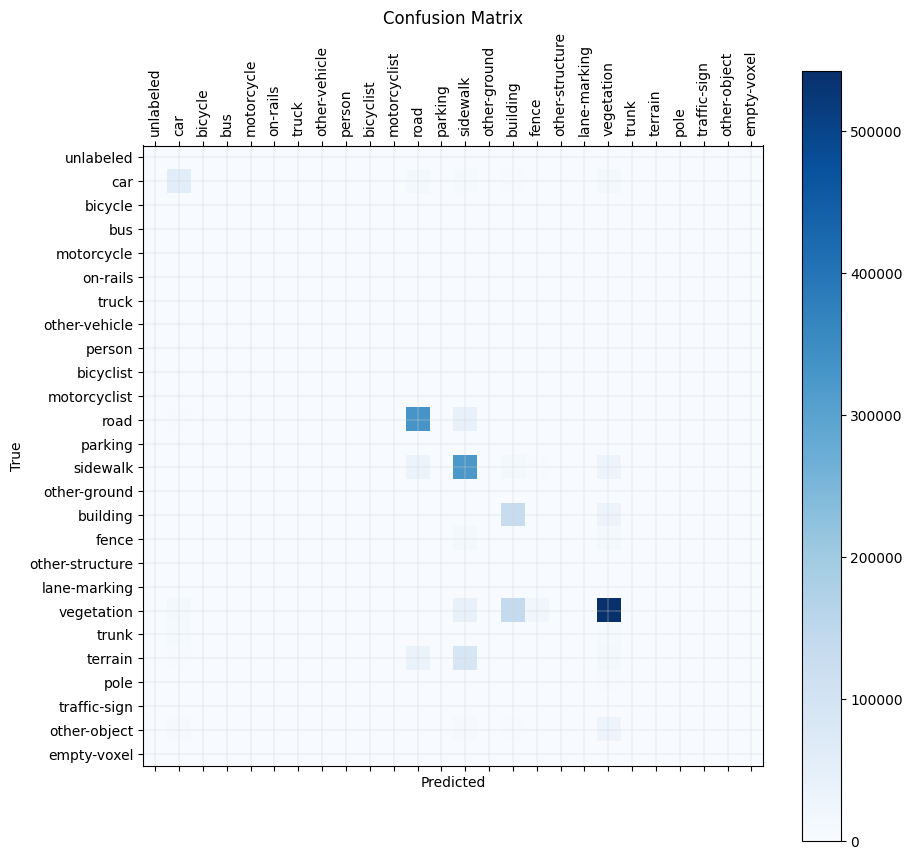

In [ ]:
confusion_matrix_np = confusion_matrix.numpy()

fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(confusion_matrix_np, cmap='Blues')
fig.colorbar(cax)

ax.set_xticks(np.arange(26))
ax.set_yticks(np.arange(26))

labels = label_name_map.values()
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

plt.xticks(rotation=90)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.grid(color = 'lightgrey', linewidth = 0.3)
plt.show()


The first thing that can be noted is that only a few classes appear among test set pointclouds.
Secondly, it can be noted from the confusion matrix and guessed by the performance metrics,
that our model is able to correctly classify the most popular classes such as *car*, *road*, *sidewalk*, *building* and *vegetation*
but lacks in performance for the others.
However, the obtained results are still acceptable thanks to the great unbalance among point classes.

Now, the average time needed by the model
to perform a complete prediction is measured
along the average partials relative to pointcloud voxelization, model prediction on the voxelgrid and label backpropagation.

In [ ]:
rounds = 30
vox_times, pred_times, back_times, tot_times = np.empty(rounds), np.empty(rounds), np.empty(rounds), np.empty(rounds)
for i in range(rounds):
  pointcloud_index = np.random.randint(1000) + 1
  pcpath    = os.path.join(dataset_path, "sequences", "00", "velodyne", str(pointcloud_index).zfill(6) + ".bin"  )
  labelpath = os.path.join(dataset_path, "sequences", "00", "labels",   str(pointcloud_index).zfill(6) + ".label")
  pointcloud, labels = readpc(pcpath, labelpath)
  start = time.time()
  pointcloud_tensor = torch.tensor(pointcloud)
  voxels, _, grid = transform_pointcloud(pointcloud_tensor, labels)
  vox_time = time.time()
  vox_times[i] = vox_time-start
  voxels = voxels.unsqueeze(0)
  voxels = voxels.to(device).float()
  lab_vox_pred = loaded_rot(voxels)
  pred_time = time.time()
  pred_times[i] = pred_time-vox_time
  lab_pt_pred = backproj(pointcloud, grid, lab_vox_pred.squeeze(0))
  back_time = time.time()
  back_times[i] = back_time-pred_time
  tot_times[i] = back_time-start

print("Mean voxelization time:", f"{vox_times.mean():.3f}s")
print("Mean true prediction time:", f"{pred_times.mean():.3f}s")
print("Mean backpropagation time:", f"{back_times.mean():.3f}s")
print("Mean total prediction time:", f"{tot_times.mean():.3f}s")

Mean voxelization time: 2.197s
Mean true prediction time: 0.011s
Mean backpropagation time: 0.911s
Mean total prediction time: 3.119s


It can be noted that the mean total prediciton time is particularly high, making the model unsuitable for real-time applications. Although, the mean ”true” prediciton
time of *VUE-net* is of only 11ms and the phases that generate the overhead in the total time are the voxelization and
backpropagation ones. Thefore, for a possibile deployment
of this model, only the implementation of these two operations shall be changed.

# PointCloud visualization


The following functions allow for pointclouds visualization.

In [ ]:
def draw_geometries(geometries):
    graph_objects = []

    for geometry in geometries:
        geometry_type = geometry.get_geometry_type()

        if geometry_type == o3d.geometry.Geometry.Type.PointCloud:
            points = np.asarray(geometry.points)
            colors = None
            if geometry.has_colors():
                colors = np.asarray(geometry.colors)
            elif geometry.has_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.normals) * 0.5
            else:
                geometry.paint_uniform_color((1.0, 0.0, 0.0))
                colors = np.asarray(geometry.colors)

            scatter_3d = go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=1, color=colors))
            graph_objects.append(scatter_3d)

        if geometry_type == o3d.geometry.Geometry.Type.TriangleMesh:
            triangles = np.asarray(geometry.triangles)
            vertices = np.asarray(geometry.vertices)
            colors = None
            if geometry.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
            else:
                colors = (1.0, 0.0, 0.0)

            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
            graph_objects.append(mesh_3d)

    fig = go.Figure(
        data=graph_objects,
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False),
                aspectmode='data'
            )
        )
    )
    fig.show()

In [ ]:
def visualize3DPointCloud(np_pointcloud, np_labels):
  """
  INPUT
      np_pointcloud : numpy array of 3D points
      np_labels     : numpy array of integer labels
  """
  assert(len(np_pointcloud) == len(np_labels))


  pcd = o3d.geometry.PointCloud()
  v3d = o3d.utility.Vector3dVector

  # set geometry point cloud points
  pcd.points = v3d(np_pointcloud)

  # scale color values in range [0:1]
  pcd.colors = o3d.utility.Vector3dVector(np_labels / 255.0)

  # replace rendering function
  o3d.visualization.draw_geometries = draw_geometries

  # visualize the colored point cloud
  o3d.visualization.draw_geometries([pcd])

In this last section the true and predicted pointcloud labels representations of sample *pointcloud_index* are compared.

In [ ]:
pointcloud_index = 901
pcpath    = os.path.join(dataset_path, "sequences", "00", "velodyne", str(pointcloud_index).zfill(6) + ".bin"  )
labelpath = os.path.join(dataset_path, "sequences", "00", "labels",   str(pointcloud_index).zfill(6) + ".label")

pointcloud, labels = readpc(pcpath, labelpath)
pointcloud_tensor = torch.tensor(pointcloud)
voxels, _, grid = transform_pointcloud(pointcloud_tensor, labels)
voxels = voxels.unsqueeze(0)
voxels = voxels.to(device).float()
lab_vox_pred = loaded_rot(voxels)
lab_pt_pred = backproj(pointcloud, grid, lab_vox_pred.squeeze(0))

labels_remapped = remap_to_bgr(labels, remap_color_scheme)
print("True Labels (remapped color scheme) :")
visualize3DPointCloud(pointcloud, labels_remapped)

labels_remapped = remap_to_bgr(lab_pt_pred.numpy(), remap_color_scheme)
print("Predicted Labels (remapped color scheme) :")
visualize3DPointCloud(pointcloud, labels_remapped)

True Labels (remapped color scheme) :


Predicted Labels (remapped color scheme) :


The observations made previously on performance agree with what can be seen from the images.
In fact, the model correcly predicts road, sidewalks, cars, buildings and vegetation but is not
able to recognize smaller, unpopular areas as the one in orange that corresponds to a fence.